Расскажите, как работает регуляризация в решающих деревьях, какие параметры мы штрафуем в данных алгоритмах?

Регуляризованные деревья штрафуются с помощью переменной, подобной переменным, выбранным на предыдущих узлах дерева для расщепления текущего узла

По какому принципу рассчитывается "важность признака (feature_importance)" в ансамблях деревьев?

Чтобы оценить важность признака, его значения перемешиваются для всех объектов
обучающей выборки и счтается out-of-bag-ошибка. Важность признака оценивается путем усреднения по всем деревьям разности показателей out-of-bag-ошибок
до и после перемешивания значений. При этом значения таких ошибок нормализуются на стандартное отклонение.

## Курсовой ##

Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

Метрика качества

F1-score (sklearn.metrics.f1_score)

Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
Решение должно содержать

Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv
Рекомендации для файла с кодом (ipynb)

Файл должен содержать заголовки и комментарии (markdown)
Повторяющиеся операции лучше оформлять в виде функций
Не делать вывод большого количества строк таблиц (5-10 достаточно)
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.
Сроки сдачи


In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.float_format = '{:.2f}'.format
FIGSIZE = (8, 13)

In [2]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import catboost as catb
import lightgbm as lgbm
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBRegressor

In [3]:
# input
DATASET_PATH = 'course_project_train.csv'
TARGET = 'Credit Default'
TEST_DATASET_PATH = 'course_project_test.csv'
# output
PREP_DATASET_PATH = 'EKalmina_predictions.csv'

## Описание датасета##

- Home Ownership - домовладение (категория)
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы (преобразовать в численный формат)
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита (категория)
- Term - срок кредита (категория)
- Current Loan Amount - текущая сумма кредита 
- Current Credit Balance - текущий кредитный баланс
- Monthly Debt - ежемесячный долг
- Сredit Score ?
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
df_train = pd.read_csv(DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,nan,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
1,Own Home,1025487.00,10+ years,0.00,15.00,15.30,1181730.00,0.00,nan,0.00,debt consolidation,Long Term,264968.00,394972.00,18373.00,737.00,1
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,nan,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
3,Own Home,805068.00,6 years,0.00,8.00,22.50,147400.00,1.00,nan,1.00,debt consolidation,Short Term,121396.00,95855.00,11338.00,694.00,0
4,Rent,776264.00,8 years,0.00,13.00,13.60,385836.00,1.00,nan,0.00,debt consolidation,Short Term,125840.00,93309.00,7180.00,719.00,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

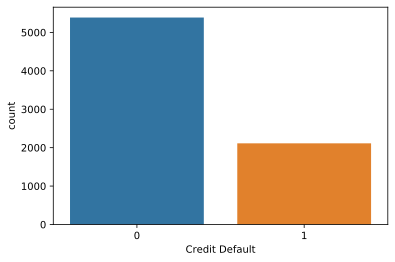

In [7]:
df_train[TARGET].value_counts()
sns.countplot(x=TARGET, data=df_train)

In [8]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.00,1366391.72,845339.20,164597.00,844341.00,1168386.00,1640137.00,10149344.00
Tax Liens,7500.00,0.03,0.27,0.00,0.00,0.00,0.00,7.00
Number of Open Accounts,7500.00,11.13,4.91,2.00,8.00,10.00,14.00,43.00
Years of Credit History,7500.00,18.32,7.04,4.00,13.50,17.00,21.80,57.70
Maximum Open Credit,7500.00,945153.73,16026216.67,0.00,279229.50,478159.00,793501.50,1304726170.00
Number of Credit Problems,7500.00,0.17,0.50,0.00,0.00,0.00,0.00,7.00
Months since last delinquent,3419.00,34.69,21.69,0.00,16.00,32.00,50.00,118.00
Bankruptcies,7486.00,0.12,0.35,0.00,0.00,0.00,0.00,4.00
Current Loan Amount,7500.00,11873177.45,31926122.97,11242.00,180169.00,309573.00,519882.00,99999999.00
Current Credit Balance,7500.00,289833.24,317871.38,0.00,114256.50,209323.00,360406.25,6506797.00


In [9]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [10]:
df_train = optimizing_df(df_train)
df_test = optimizing_df(df_test)

In [11]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

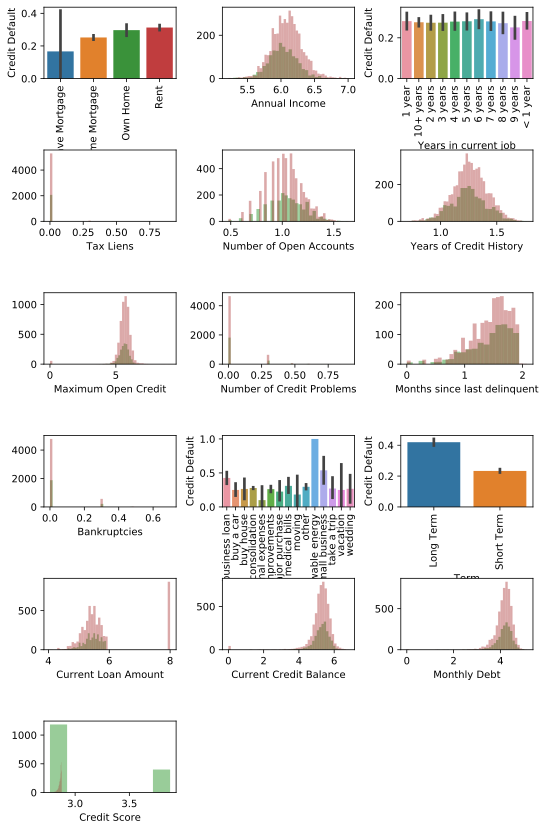

In [12]:
cat_list = list(df_train.loc[:, ~df_train.columns.isin(['Id', 'Credit Default'])])
ncols = 3
nrows = math.ceil(len(cat_list) / ncols)
index = 1
fig,ax = plt.subplots(figsize=FIGSIZE, ncols=1)
for col_name in cat_list:
    plt.subplot(nrows, ncols, index)
    index += 1    
    if df_train[col_name].dtypes.kind == 'O':
        g = sns.barplot(x=col_name, y=TARGET, data=df_train)
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    else:
        sns.distplot(np.log10(df_train[df_train[TARGET] == 1][col_name].dropna().values+1), kde=False, color="green")
        sns.distplot(np.log10(df_train[df_train[TARGET] == 0][col_name].dropna().values+1), kde=False, color="brown", axlabel=col_name)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1, wspace=0.35)
ax.autoscale(enable=True) 
plt.show()

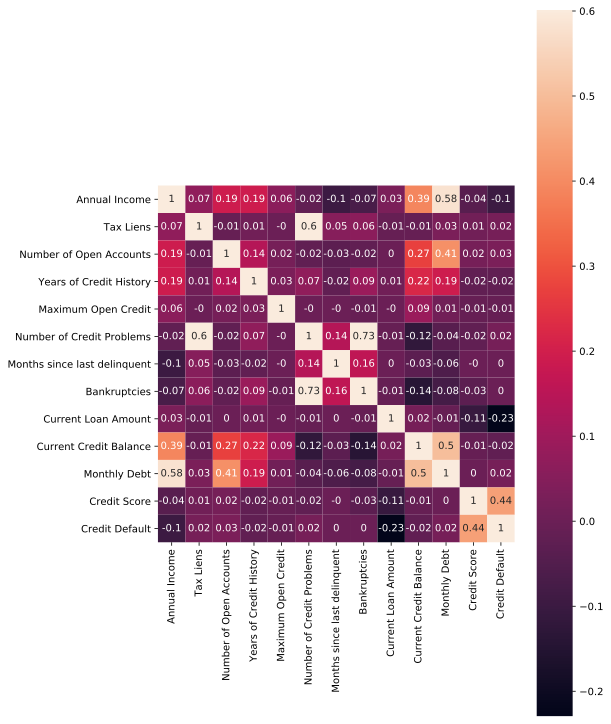

In [13]:
corrmat = df_train.corr().round(2)
plt.subplots(figsize=FIGSIZE)
sns.heatmap(corrmat, vmax=0.6, square=True, annot=True)

Уже очевидна большая корреляция с кредитным скорингом.
А также корреляция между числом открытых счетов, и ежемесячным долгом..

### Приведение типов и чистка пропусков

In [14]:
df_train['Years in current job'].unique()

[NaN, 10+ years, 8 years, 6 years, 7 years, ..., < 1 year, 4 years, 3 years, 2 years, 9 years]
Length: 12
Categories (11, object): [10+ years, 8 years, 6 years, 7 years, ..., 4 years, 3 years, 2 years, 9 years]

In [15]:
df_test['Years in current job'].unique()

[4 years, 1 year, 3 years, 10+ years, 6 years, ..., 2 years, 9 years, 8 years, 7 years, NaN]
Length: 12
Categories (11, object): [4 years, 1 year, 3 years, 10+ years, ..., 2 years, 9 years, 8 years, 7 years]

In [16]:
def missing_values_clean(df):
    
    if pd.api.types.is_categorical_dtype(df['Years in current job']):
        df['Years in current job'] = df['Years in current job'].cat.add_categories(['0'])
    
    df['Years in current job'] = df['Years in current job'].fillna('0')

    df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)

    df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
    
    return df

In [17]:
def years_in_current_job_clean(years):
    if isinstance(years, str):
        years = years.rstrip('s').rstrip('year').rstrip().rstrip('+')
        if years.startswith('<'):
            years = '0'   
    return years

In [18]:
def years_clean(df):
    df['Years in current job'] = df['Years in current job'].map(years_in_current_job_clean)
    df['Years in current job'] = df['Years in current job'].astype(float)
    return df

In [19]:
df_train = missing_values_clean(df_train)
df_test = missing_values_clean(df_test)

In [20]:
df_train = years_clean(df_train)
df_test = years_clean(df_test)


In [21]:
df_train['Years in current job'].unique()

array([ 0., 10.,  8.,  6.,  7.,  5.,  1.,  4.,  3.,  2.,  9.])

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7500 non-null   float64 
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  7500 non-null   float32 
 9   Bankruptcies                  7500 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [23]:
FEATURES = list(df_train.drop([TARGET], axis=1))
NUM_FEATURES = list(df_train[FEATURES].select_dtypes(include='number'))

In [24]:
le = LabelEncoder() 
df_train['Home Ownership']= le.fit_transform(df_train['Home Ownership'])
df_test['Home Ownership']= le.fit_transform(df_test['Home Ownership']) 

df_train['Years in current job']= le.fit_transform(df_train['Years in current job'])
df_test['Years in current job']= le.fit_transform(df_test['Years in current job']) 

df_train['Purpose']= le.fit_transform(df_train['Purpose'])
df_test['Purpose']= le.fit_transform(df_test['Purpose']) 

df_train['Term']= le.fit_transform(df_train['Term'])
df_test['Term']= le.fit_transform(df_test['Term']) 

In [25]:
scaler = StandardScaler()
df_norm = df_train.copy()
df_norm[NUM_FEATURES] = scaler.fit_transform(df_norm[NUM_FEATURES])
df_train = df_norm.copy()
df_norm = df_test.copy()
df_norm[NUM_FEATURES] = scaler.transform(df_norm[NUM_FEATURES])
df_test = df_norm.copy()

In [26]:
df_train['Annual Income'] = df_train['Annual Income'].fillna(-999)
df_test['Annual Income'] = df_test['Annual Income'].fillna(-999)

In [27]:
df_train['Credit Score'] = df_train['Credit Score'].fillna(-999)
df_test['Credit Score'] = df_test['Credit Score'].fillna(-999)

In [28]:
X = df_train[FEATURES]
y = df_train[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)

In [29]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.values.argmax()
    minor_class_name = target_counts.values.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [30]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET)
    
df_balanced[TARGET].value_counts()
X_train = df_balanced.drop(columns=TARGET)
y_train = df_balanced[TARGET]

In [31]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [32]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [33]:
def select_model(df, features):
    all_X = df[features]
    all_y = df[TARGET]
    
    cv=KFold(n_splits=3, random_state=21, shuffle=True)
        
    LogisticRegression_dict = {
        'model_name': 'Logistic Regression',
        'estimator': LogisticRegression(),
        'hyperparams': {
            'C': np.arange(1, 5, 1),
            'class_weight': [None, 'balanced'],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'max_iter': np.arange(100, 200, 10)
        }
    }
    
    KNeighborsClassifier_dict = {
        'model_name': 'K Nearest Neighbours',
        'estimator': KNeighborsClassifier(),
        'hyperparams': {
            'algorithm': ['ball_tree', 'kd_tree', 'brute'],
            'leaf_size': np.arange(1, 20, 1),
            'n_neighbors': np.arange(1, 5, 1),
            'p': [1, 2],
            'weights': ['distance', 'uniform']
        }
    }
    
    XGBClassifier_dict = {
        'model_name': 'XGBoost',
        'estimator': xgb.XGBClassifier(),
        'hyperparams': { 
        'learning_rate': np.arange(0.01, 1.0, 0.05),
        'n_estimators': np.arange(200, 800, 50),
        'max_depth': np.arange(3, 10, 1),
        'min_child_weight': np.arange(5, 15, 1),
        'subsample': np.arange(0.7, 1.5, 1),
        'colsample': np.arange(0.5, 1.5, 0.1),
        'colsample_bytree': np.arange(0.5, 1.0, 0.1),
        'gamma': np.arange(0, 5, 1),
        'reg_alpha': np.arange(0.01, 0.1, 0.01)
        }  
    }
    
    LGBMClassifier_dict = {
        'model_name': 'LightGBM',
        'estimator': lgbm.LGBMClassifier(),
        'hyperparams': {
             'boosting_type': ['gbdt'],
             'learning_rate': np.arange(0.01, 1.0, 0.05),
             'max_depth': np.arange(3, 10, 1),
             'min_child_weight': np.arange(0.001, 1, 0.005),
             'n_estimators': np.arange(100, 500, 50),
             'num_leaves': np.arange(10, 50, 5),
             'reg_alpha': np.arange(0.0, 1.5, 0.05),
             'reg_lambda': np.arange(0.0, 1.0, 0.05),
             'subsample': np.arange(0.2, 1.0, 0.1),
             'is_unbalance': [True, False],
        }  
    }
    
    CatBoostClassifier_dict = {
        'model_name': 'CatBoost',
        'estimator': catb.CatBoostClassifier(silent=True),
        'hyperparams': {
             'max_depth': np.arange(1, 10, 1),
             'n_estimators': np.arange(500, 1500, 50),
             'learning_rate': np.arange(0.01, 1.0, 0.05),
             'od_type': ['IncToDec', 'Iter'],
             'l2_leaf_reg': [10, 100, 5],
        }  
    }
    
    AdaBoostClassifier_dict = {
        'model_name': 'Ada Boost',
        'estimator': AdaBoostClassifier(),
        'hyperparams': {
             'algorithm': ['SAMME', 'SAMME.R'],
             'learning_rate': np.arange(0.01, 1.0, 0.05),
             'n_estimators': np.arange(100, 1000, 50),
        }  
    }
    
    SVC_dict = {
        'model_name': 'Support Vector Machine',
        'estimator': SVC(),
        'hyperparams': { 
            'C': np.arange(0.5, 5, 0.5),
            'class_weight': ['balanced'],
            'gamma': np.arange(1, 5, 1),
            'kernel': ['rbf'],
        }  
    }
    
    ExtraTreesClassifier_dict = {
        'model_name': 'Extremely Randomised Trees',
        'estimator': ExtraTreesClassifier(),
        'hyperparams': { 
              'n_estimators': np.arange(100, 1000, 100),
              'min_samples_split': np.arange(0, 1, 0.1),
              'class_weight': ['balanced', 'balanced_subsample',  None],
              'max_depth': np.arange(1, 10, 1),
        }  
    }
    
    GradientBoostingClassifier_dict = {
        'model_name': 'Gradient Boosting',
        'estimator': GradientBoostingClassifier(),
        'hyperparams': { 
              'max_depth': np.arange(1, 10, 1),
              'n_estimators': np.arange(5, 500, 10),
              'learning_rate': np.arange(0.01, 10, 0.05),
        }  
    }
    
    hyper_params_list = [
        LogisticRegression_dict,
        KNeighborsClassifier_dict,
        XGBClassifier_dict,
        LGBMClassifier_dict,
        CatBoostClassifier_dict,
        AdaBoostClassifier_dict,
        SVC_dict,
        ExtraTreesClassifier_dict,
        GradientBoostingClassifier_dict,
    ]    
    
    scores = {}
    for model in hyper_params_list:
        print('-'*len(model['model_name']))
        print(model['model_name'])
        print('-'*len(model['model_name']))
        
        estimator = model['estimator']
        grid = RandomizedSearchCV(estimator, model['hyperparams'], scoring='f1', cv=cv, n_jobs=-1)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_ 
        model["best_model"] = grid.best_estimator_
        scores[model['model_name']] = grid.best_score_ 
        
        print('Best Score: ' + str(model['best_score']))
        print('Best Parameters: ' + str(model['best_params']))
    
    best_model = max(scores, key=scores.get)
    print('-'*len('Best Model: ' + str(best_model)))       
    print('Best Model: ' + str(best_model))
    print('-'*len('Best Model: ' + str(best_model)))   
    
    for model in hyper_params_list:
        if model['model_name'] == best_model:       
            print('Best Model Score: ' + str(model['best_score']))
            print('Best Model Parameters:' + str(model['best_params']))

    return hyper_params_list

In [34]:
hyper_params_list = select_model(df_train, FEATURES)

-------------------
Logistic Regression
-------------------
Best Score: 0.5357073760666959
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 140, 'class_weight': 'balanced', 'C': 2}
--------------------
K Nearest Neighbours
--------------------
Best Score: 0.44289369625639496
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 2, 'leaf_size': 15, 'algorithm': 'kd_tree'}
-------
XGBoost
-------
Best Score: 0.4675652641108383
Best Parameters: {'subsample': 0.7, 'reg_alpha': 0.04, 'n_estimators': 200, 'min_child_weight': 11, 'max_depth': 4, 'learning_rate': 0.51, 'gamma': 4, 'colsample_bytree': 0.7999999999999999, 'colsample': 0.9999999999999999}
--------
LightGBM
--------
Best Score: 0.5131648777757468
Best Parameters: {'subsample': 0.8000000000000003, 'reg_lambda': 0.15000000000000002, 'reg_alpha': 0.6000000000000001, 'num_leaves': 20, 'n_estimators': 150, 'min_child_weight': 0.17600000000000002, 'max_depth': 7, 'learning_rate': 0.01, 'is_unbalance': True

In [35]:
result_model_score = {}

In [45]:
model_lr = LogisticRegression(
    solver='liblinear', 
    penalty='l2',
    max_iter=140,
    class_weight='balanced',
    C=2,
)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_lr
model_score['model_name'] = 'model_lr'

result_model_score['Logistic Regression'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      3795
           1       0.62      0.66      0.64      2910

    accuracy                           0.68      6705
   macro avg       0.67      0.68      0.67      6705
weighted avg       0.68      0.68      0.68      6705

TEST

              precision    recall  f1-score   support

           0       0.83      0.67      0.74      1592
           1       0.46      0.67      0.54       658

    accuracy                           0.67      2250
   macro avg       0.64      0.67      0.64      2250
weighted avg       0.72      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1068  524
1                220  438


In [46]:
model_knn = KNeighborsClassifier(
    weights='distance',
    p=1,
    n_neighbors=2,
    leaf_size=15,
    algorithm='kd_tree',
)
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_knn
model_score['model_name'] = 'model_knn'
result_model_score['K Nearest Neighbours'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3795
           1       1.00      1.00      1.00      2910

    accuracy                           1.00      6705
   macro avg       1.00      1.00      1.00      6705
weighted avg       1.00      1.00      1.00      6705

TEST

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1592
           1       0.46      0.45      0.46       658

    accuracy                           0.68      2250
   macro avg       0.62      0.62      0.62      2250
weighted avg       0.68      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1241  351
1                359  299


In [48]:
model_xgb = xgb.XGBClassifier(
    subsample=0.7,
    reg_alpha=0.04,
    n_estimators=200,
    min_child_weight=11,
    max_depth=4,
    learning_rate=0.51,
    gamma=4,
    colsample_bytree=0.8,
    colsample=0.99,
    n_jobs=-1,
    random_state=21
)

model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_xgb
model_score['model_name'] = 'model_xgb'
result_model_score['XGBoost'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3795
           1       0.89      0.89      0.89      2910

    accuracy                           0.91      6705
   macro avg       0.90      0.91      0.91      6705
weighted avg       0.91      0.91      0.91      6705

TEST

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1592
           1       0.49      0.50      0.50       658

    accuracy                           0.70      2250
   macro avg       0.64      0.64      0.64      2250
weighted avg       0.70      0.70      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1255  337
1                330  328


In [49]:
model_lgbm = lgbm.LGBMClassifier(
    subsample=0.8,
    reg_lambda=0.15,
    reg_alpha=0.6,
    num_leaves=20,
    n_estimators=150,
    min_child_weight=0.176,
    max_depth=7,
    learning_rate=0.01,
    is_unbalance=True,
    boosting_type='gbdt',
    n_jobs=-1,
    random_state=42
)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['name'] = 'LightGBM'
model_score['model'] = model_lgbm
model_score['model_name'] = 'model_lgbm'
result_model_score['LightGBM'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3795
           1       0.73      0.67      0.70      2910

    accuracy                           0.75      6705
   macro avg       0.74      0.74      0.74      6705
weighted avg       0.75      0.75      0.75      6705

TEST

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1592
           1       0.50      0.57      0.54       658

    accuracy                           0.71      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.72      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1221  371
1                282  376


In [50]:
model_catb = catb.CatBoostClassifier(
    od_type='Iter',
    n_estimators=1200,
    max_depth=3,
    learning_rate=0.61, 
    l2_leaf_reg=100,
    random_state=42,
)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_catb
model_score['model_name'] = 'model_catb'
result_model_score['CatBoost'] = model_score

0:	learn: 0.5846760	total: 4.23ms	remaining: 5.07s
1:	learn: 0.5717516	total: 7.86ms	remaining: 4.71s
2:	learn: 0.5622347	total: 13.3ms	remaining: 5.29s
3:	learn: 0.5500414	total: 18.3ms	remaining: 5.46s
4:	learn: 0.5426885	total: 22.5ms	remaining: 5.38s
5:	learn: 0.5385568	total: 26.6ms	remaining: 5.29s
6:	learn: 0.5360246	total: 30.9ms	remaining: 5.26s
7:	learn: 0.5335524	total: 34.7ms	remaining: 5.16s
8:	learn: 0.5307837	total: 39.9ms	remaining: 5.28s
9:	learn: 0.5298240	total: 43.3ms	remaining: 5.16s
10:	learn: 0.5285550	total: 46.9ms	remaining: 5.07s
11:	learn: 0.5271900	total: 52.1ms	remaining: 5.16s
12:	learn: 0.5262419	total: 55.2ms	remaining: 5.04s
13:	learn: 0.5244786	total: 57.4ms	remaining: 4.86s
14:	learn: 0.5225617	total: 60ms	remaining: 4.74s
15:	learn: 0.5212766	total: 62.2ms	remaining: 4.6s
16:	learn: 0.5205047	total: 65.5ms	remaining: 4.56s
17:	learn: 0.5195225	total: 69.7ms	remaining: 4.58s
18:	learn: 0.5178574	total: 71.9ms	remaining: 4.47s
19:	learn: 0.5143992	tota

182:	learn: 0.3834905	total: 396ms	remaining: 2.2s
183:	learn: 0.3832879	total: 399ms	remaining: 2.2s
184:	learn: 0.3832115	total: 402ms	remaining: 2.2s
185:	learn: 0.3831771	total: 405ms	remaining: 2.21s
186:	learn: 0.3826933	total: 407ms	remaining: 2.21s
187:	learn: 0.3826646	total: 410ms	remaining: 2.21s
188:	learn: 0.3825464	total: 413ms	remaining: 2.21s
189:	learn: 0.3824473	total: 419ms	remaining: 2.23s
190:	learn: 0.3819916	total: 425ms	remaining: 2.24s
191:	learn: 0.3816950	total: 429ms	remaining: 2.25s
192:	learn: 0.3809509	total: 433ms	remaining: 2.26s
193:	learn: 0.3805119	total: 437ms	remaining: 2.27s
194:	learn: 0.3802669	total: 443ms	remaining: 2.28s
195:	learn: 0.3800237	total: 445ms	remaining: 2.28s
196:	learn: 0.3799293	total: 447ms	remaining: 2.28s
197:	learn: 0.3790071	total: 449ms	remaining: 2.27s
198:	learn: 0.3785940	total: 452ms	remaining: 2.27s
199:	learn: 0.3781057	total: 454ms	remaining: 2.27s
200:	learn: 0.3770267	total: 458ms	remaining: 2.27s
201:	learn: 0.3

377:	learn: 0.3143031	total: 788ms	remaining: 1.71s
378:	learn: 0.3141159	total: 791ms	remaining: 1.71s
379:	learn: 0.3134535	total: 794ms	remaining: 1.71s
380:	learn: 0.3132767	total: 797ms	remaining: 1.71s
381:	learn: 0.3132696	total: 799ms	remaining: 1.71s
382:	learn: 0.3132543	total: 802ms	remaining: 1.71s
383:	learn: 0.3132539	total: 804ms	remaining: 1.71s
384:	learn: 0.3132533	total: 806ms	remaining: 1.71s
385:	learn: 0.3131592	total: 808ms	remaining: 1.7s
386:	learn: 0.3131580	total: 814ms	remaining: 1.71s
387:	learn: 0.3128005	total: 817ms	remaining: 1.71s
388:	learn: 0.3121288	total: 820ms	remaining: 1.71s
389:	learn: 0.3121275	total: 823ms	remaining: 1.71s
390:	learn: 0.3121241	total: 826ms	remaining: 1.71s
391:	learn: 0.3121241	total: 829ms	remaining: 1.71s
392:	learn: 0.3120014	total: 832ms	remaining: 1.71s
393:	learn: 0.3115143	total: 835ms	remaining: 1.71s
394:	learn: 0.3110498	total: 838ms	remaining: 1.71s
395:	learn: 0.3108373	total: 841ms	remaining: 1.71s
396:	learn: 0

594:	learn: 0.2587215	total: 1.38s	remaining: 1.4s
595:	learn: 0.2583271	total: 1.38s	remaining: 1.4s
596:	learn: 0.2579289	total: 1.38s	remaining: 1.4s
597:	learn: 0.2574048	total: 1.39s	remaining: 1.4s
598:	learn: 0.2573682	total: 1.39s	remaining: 1.39s
599:	learn: 0.2572258	total: 1.39s	remaining: 1.39s
600:	learn: 0.2567114	total: 1.39s	remaining: 1.39s
601:	learn: 0.2564330	total: 1.4s	remaining: 1.39s
602:	learn: 0.2562353	total: 1.4s	remaining: 1.38s
603:	learn: 0.2560131	total: 1.4s	remaining: 1.38s
604:	learn: 0.2560091	total: 1.4s	remaining: 1.38s
605:	learn: 0.2555142	total: 1.4s	remaining: 1.38s
606:	learn: 0.2552352	total: 1.4s	remaining: 1.37s
607:	learn: 0.2549764	total: 1.41s	remaining: 1.37s
608:	learn: 0.2548099	total: 1.41s	remaining: 1.37s
609:	learn: 0.2547998	total: 1.41s	remaining: 1.37s
610:	learn: 0.2547981	total: 1.42s	remaining: 1.36s
611:	learn: 0.2547542	total: 1.42s	remaining: 1.36s
612:	learn: 0.2546206	total: 1.42s	remaining: 1.36s
613:	learn: 0.2546110	

780:	learn: 0.2186641	total: 1.77s	remaining: 951ms
781:	learn: 0.2183975	total: 1.78s	remaining: 949ms
782:	learn: 0.2183936	total: 1.78s	remaining: 948ms
783:	learn: 0.2182408	total: 1.78s	remaining: 947ms
784:	learn: 0.2177856	total: 1.79s	remaining: 945ms
785:	learn: 0.2176168	total: 1.79s	remaining: 944ms
786:	learn: 0.2173913	total: 1.8s	remaining: 945ms
787:	learn: 0.2169733	total: 1.8s	remaining: 944ms
788:	learn: 0.2169462	total: 1.81s	remaining: 942ms
789:	learn: 0.2168261	total: 1.81s	remaining: 941ms
790:	learn: 0.2166954	total: 1.82s	remaining: 941ms
791:	learn: 0.2165852	total: 1.82s	remaining: 939ms
792:	learn: 0.2164100	total: 1.83s	remaining: 939ms
793:	learn: 0.2163988	total: 1.84s	remaining: 940ms
794:	learn: 0.2163754	total: 1.84s	remaining: 939ms
795:	learn: 0.2163605	total: 1.85s	remaining: 939ms
796:	learn: 0.2162825	total: 1.85s	remaining: 937ms
797:	learn: 0.2159939	total: 1.86s	remaining: 937ms
798:	learn: 0.2156765	total: 1.86s	remaining: 936ms
799:	learn: 0.

984:	learn: 0.1854146	total: 2.36s	remaining: 515ms
985:	learn: 0.1854146	total: 2.36s	remaining: 512ms
986:	learn: 0.1852666	total: 2.36s	remaining: 510ms
987:	learn: 0.1850893	total: 2.36s	remaining: 507ms
988:	learn: 0.1849420	total: 2.37s	remaining: 505ms
989:	learn: 0.1845906	total: 2.37s	remaining: 503ms
990:	learn: 0.1843795	total: 2.37s	remaining: 500ms
991:	learn: 0.1840711	total: 2.37s	remaining: 498ms
992:	learn: 0.1839893	total: 2.38s	remaining: 495ms
993:	learn: 0.1838568	total: 2.38s	remaining: 493ms
994:	learn: 0.1838568	total: 2.38s	remaining: 491ms
995:	learn: 0.1837473	total: 2.38s	remaining: 489ms
996:	learn: 0.1837472	total: 2.39s	remaining: 486ms
997:	learn: 0.1837472	total: 2.39s	remaining: 484ms
998:	learn: 0.1837472	total: 2.39s	remaining: 482ms
999:	learn: 0.1837435	total: 2.4s	remaining: 479ms
1000:	learn: 0.1837434	total: 2.4s	remaining: 477ms
1001:	learn: 0.1837434	total: 2.4s	remaining: 474ms
1002:	learn: 0.1836407	total: 2.4s	remaining: 471ms
1003:	learn: 

1187:	learn: 0.1674586	total: 2.75s	remaining: 27.8ms
1188:	learn: 0.1674582	total: 2.75s	remaining: 25.5ms
1189:	learn: 0.1673887	total: 2.75s	remaining: 23.2ms
1190:	learn: 0.1673805	total: 2.76s	remaining: 20.8ms
1191:	learn: 0.1673546	total: 2.76s	remaining: 18.5ms
1192:	learn: 0.1672746	total: 2.76s	remaining: 16.2ms
1193:	learn: 0.1672740	total: 2.77s	remaining: 13.9ms
1194:	learn: 0.1672739	total: 2.77s	remaining: 11.6ms
1195:	learn: 0.1671574	total: 2.77s	remaining: 9.27ms
1196:	learn: 0.1671573	total: 2.77s	remaining: 6.95ms
1197:	learn: 0.1671571	total: 2.78s	remaining: 4.64ms
1198:	learn: 0.1670620	total: 2.78s	remaining: 2.32ms
1199:	learn: 0.1669932	total: 2.78s	remaining: 0us
TRAIN

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3795
           1       0.97      0.98      0.97      2910

    accuracy                           0.98      6705
   macro avg       0.98      0.98      0.98      6705
weighted avg       0.9

In [51]:
model_ada = AdaBoostClassifier(
    n_estimators=900,
    learning_rate=0.81,
    algorithm='SAMME.R',
)
model_ada.fit(X_train, y_train)

y_train_pred = model_ada.predict(X_train)
y_test_pred = model_ada.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_ada
model_score['model_name'] = 'model_ada'
result_model_score['Ada Boost'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.83      0.80      3795
           1       0.75      0.66      0.71      2910

    accuracy                           0.76      6705
   macro avg       0.76      0.75      0.75      6705
weighted avg       0.76      0.76      0.76      6705

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1592
           1       0.53      0.57      0.54       658

    accuracy                           0.72      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.73      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1256  336
1                286  372


In [52]:
model_svm = SVC(
    kernel='rbf',
    C=1.5, 
    class_weight='balanced', 
    gamma=1
)
model_svm.fit(X_train, y_train)

y_train_pred = model_svm.predict(X_train)
y_test_pred = model_svm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_svm
model_score['model_name'] = 'model_svm'
result_model_score['Support Vector Machine'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3795
           1       0.96      0.98      0.97      2910

    accuracy                           0.97      6705
   macro avg       0.97      0.97      0.97      6705
weighted avg       0.97      0.97      0.97      6705

TEST

              precision    recall  f1-score   support

           0       0.74      0.86      0.79      1592
           1       0.43      0.25      0.32       658

    accuracy                           0.68      2250
   macro avg       0.58      0.56      0.56      2250
weighted avg       0.65      0.68      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1372  220
1                493  165


In [53]:
model_pctr = Perceptron(class_weight='balanced')
model_pctr = model_pctr.fit(X_train, y_train)

y_train_pred = model_pctr.predict(X_train)
y_test_pred = model_pctr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_pctr
model_score['model_name'] = 'model_pctr'
result_model_score['Perceptron'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.44      0.57      3795
           1       0.54      0.86      0.66      2910

    accuracy                           0.62      6705
   macro avg       0.67      0.65      0.62      6705
weighted avg       0.69      0.62      0.61      6705

TEST

              precision    recall  f1-score   support

           0       0.89      0.43      0.58      1592
           1       0.38      0.87      0.53       658

    accuracy                           0.55      2250
   macro avg       0.63      0.65      0.55      2250
weighted avg       0.74      0.55      0.56      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               678  914
1                88  570


In [54]:
model_bay = GaussianNB()
model_bay = model_bay.fit(X_train, y_train)

y_train_pred = model_bay.predict(X_train)
y_test_pred = model_bay.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_bay
model_score['model_name'] = 'model_bay'
result_model_score['Naive Bayes'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.18      0.30      3795
           1       0.48      0.99      0.65      2910

    accuracy                           0.53      6705
   macro avg       0.72      0.58      0.47      6705
weighted avg       0.75      0.53      0.45      6705

TEST

              precision    recall  f1-score   support

           0       0.99      0.18      0.30      1592
           1       0.33      1.00      0.50       658

    accuracy                           0.42      2250
   macro avg       0.66      0.59      0.40      2250
weighted avg       0.80      0.42      0.36      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               286  1306
1                 2   656


In [55]:
model_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=100,
    max_depth=6,
    min_samples_split=0.1,
    class_weight='balanced',
    )
model_ext = model_ext.fit(X_train, y_train)

y_train_pred = model_ext.predict(X_train)
y_test_pred = model_ext.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_ext
model_score['model_name'] = 'model_ext'
result_model_score['Extremely Randomised Trees'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      3795
           1       0.63      0.63      0.63      2910

    accuracy                           0.68      6705
   macro avg       0.67      0.67      0.67      6705
weighted avg       0.68      0.68      0.68      6705

TEST

              precision    recall  f1-score   support

           0       0.82      0.70      0.76      1592
           1       0.46      0.63      0.53       658

    accuracy                           0.68      2250
   macro avg       0.64      0.66      0.65      2250
weighted avg       0.72      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1115  477
1                244  414


In [56]:
model_gb = GradientBoostingClassifier(
            n_estimators=105,
            learning_rate=6.96,
            max_depth=3,
            random_state=42)

model_gb.fit(X_train, y_train)

y_train_pred = model_gb.predict(X_train)
y_test_pred = model_gb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_gb
model_score['model_name'] = 'model_gb'
result_model_score['Gradient Boosting'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3795
           1       0.63      0.51      0.56      2910

    accuracy                           0.66      6705
   macro avg       0.65      0.64      0.64      6705
weighted avg       0.66      0.66      0.65      6705

TEST

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1592
           1       0.46      0.50      0.48       658

    accuracy                           0.68      2250
   macro avg       0.62      0.63      0.62      2250
weighted avg       0.69      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1201  391
1                329  329


In [57]:
model_vote = VotingClassifier(
    estimators=[
        ('Logistic Regression', model_lr),
        ('Extremely Randomised Trees', model_ext),
        ('Support Vector Machine', model_svm),
        ('LightGBM', model_lgbm),
        ('Naive Bayes', model_bay),
        ('Gradient Boosting', model_gb),
        ('XGBoost', model_xgb),
        ('Ada Boost', model_ada),
        ('K Nearest Neighbours', model_knn),
        ('Perceptron', model_pctr)
    ],
    voting='hard',
    n_jobs=-1)

model_vote.fit(X_train, y_train)

y_train_pred = model_vote.predict(X_train)
y_test_pred = model_vote.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_vote
model_score['model_name'] = 'model_vote'
result_model_score['Voting Classifier'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3795
           1       0.81      0.79      0.80      2910

    accuracy                           0.83      6705
   macro avg       0.83      0.82      0.82      6705
weighted avg       0.83      0.83      0.83      6705

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1592
           1       0.53      0.56      0.54       658

    accuracy                           0.73      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1264  328
1                290  368


In [44]:
name_list = []
for name, model_score in result_model_score.items():
    name_list.append([
                    name, model_score['0']['f1-score'], \
                    model_score['1']['f1-score'], \
                    model_score['model_name'], \
                    model_score['model']
                     ])

In [58]:
models_score = pd.DataFrame(name_list, columns=[
                    'Name', \
                    'Score_0', \
                    'Score_1', \
                    'Model Name', \
                    'Model'
                    ],) \
                .sort_values(by='Score_1', ascending=False) \
                .reset_index(drop=True)
models_score

,Name,Score_0,Score_1,Model Name,Model
0,Ada Boost,0.80,0.54,model_ada,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
1,Logistic Regression,0.74,0.54,model_lr,"LogisticRegression(C=2, class_weight='balanced..."
2,Perceptron,0.58,0.53,model_pctr,"Perceptron(alpha=0.0001, class_weight='balance..."
3,Support Vector Machine,0.77,0.52,model_svm,"SVC(C=0.5, break_ties=False, cache_size=200, c..."
4,LightGBM,0.79,0.51,model_lgbm,"LGBMClassifier(boosting_type='gbdt', class_wei..."
5,XGBoost,0.81,0.50,model_xgb,"XGBClassifier(base_score=0.5, booster='gbtree'..."
6,CatBoost,0.80,0.49,model_catb,<catboost.core.CatBoostClassifier object at 0x...
7,K Nearest Neighbours,0.78,0.46,model_knn,"KNeighborsClassifier(algorithm='ball_tree', le..."


In [62]:
model_final = models_score.Model[0]
print(f'The best model is {models_score.Name[0]}')

The best model is Ada Boost


In [80]:
model_fin= model_ada.fit(X,y)

In [81]:
y_test_pred_probs = model_fin.predict_proba(X_test)

/home/janecalm/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


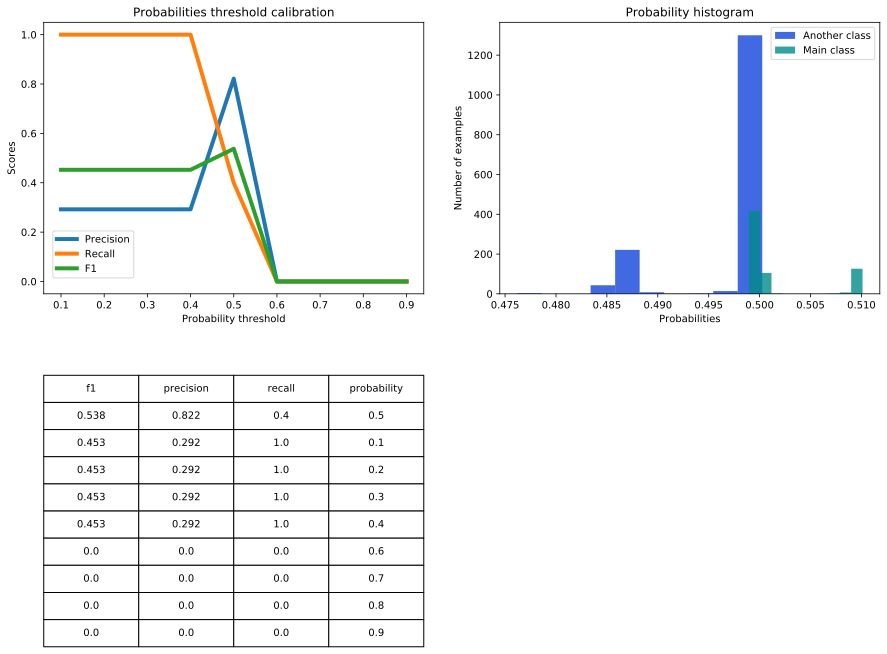

In [82]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [83]:
df_test["CREDIT_DEFAULT"] = model_fin.predict(df_test[FEATURES])

In [84]:

df_test.loc[:, ['CREDIT_DEFAULT']].to_csv(PREP_DATASET_PATH, index=False)